In [ ]:
!pip install pathway bokeh --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import time

output_notebook()

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('dataset.csv')
df.head()

Saving dataset.csv to dataset.csv


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
# Combine LastUpdatedDate & LastUpdatedTime safely using dayfirst=True
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True, errors='coerce'
)

# Drop rows where Timestamp couldn't be parsed
df = df.dropna(subset=['Timestamp'])

# Rename for clarity
df.rename(columns={
    'SystemCodeNumber': 'ParkingLotID',
    'TrafficConditionNearby': 'Traffic'
}, inplace=True)

# Map traffic condition to numerical values
traffic_map = {'Low': 0.2, 'Medium': 0.5, 'High': 1.0}
df['Traffic'] = df['Traffic'].map(traffic_map)

# Map vehicle types
vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)

# Sort for modeling
df = df.sort_values(by=['ParkingLotID', 'Timestamp']).reset_index(drop=True)

df[['ParkingLotID', 'Timestamp', 'Occupancy', 'Capacity', 'Traffic', 'QueueLength', 'VehicleWeight']].head()


,ParkingLotID,Timestamp,Occupancy,Capacity,Traffic,QueueLength,VehicleWeight
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,NaN,1,1.0
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,NaN,1,1.0
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,NaN,2,1.0
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,NaN,2,1.0
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,NaN,2,0.5


In [ ]:
import pandas as pd

# Load the full dataset
df = pd.read_csv('/content/dataset.csv')
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [ ]:
df['SystemCodeNumber'].nunique()


14

In [ ]:
df.shape


(18368, 12)

In [ ]:
df['SystemCodeNumber'].unique()

array(['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01', 'BHMMBMMBX01',
       'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a',
       'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202',
       'Others-CCCPS8', 'Others-CCCPS98', 'Shopping'], dtype=object)

In [ ]:
df.rename(columns={'SystemCodeNumber': 'ParkingLotID'}, inplace=True)
print(df.columns)


Index(['ID', 'ParkingLotID', 'Capacity', 'Latitude', 'Longitude', 'Occupancy',
       'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay',
       'LastUpdatedDate', 'LastUpdatedTime'],
      dtype='object')


In [ ]:
def linear_price(prev_price, occupancy, capacity, alpha=2.0):
    return prev_price + alpha * (occupancy / capacity)

In [ ]:
all_lot_linear_results = []
base_price = 10  # Start from $10

for lot_id in df['ParkingLotID'].unique():
    lot_df = df[df['ParkingLotID'] == lot_id].copy().reset_index(drop=True)

    linear_prices = [base_price]

    for i in range(1, len(lot_df)):
        prev_price = linear_prices[-1]
        occ = lot_df.loc[i, 'Occupancy']
        cap = lot_df.loc[i, 'Capacity']

        new_price = linear_price(prev_price, occ, cap)
        linear_prices.append(new_price)

    lot_df['LinearPrice'] = linear_prices
    all_lot_linear_results.append(lot_df)

In [ ]:
# First confirm Timestamp still exists in df
print('Timestamp' in df.columns)  # Should return True


False


In [ ]:
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True,
    errors='coerce'
)

In [ ]:
def linear_price(prev_price, occupancy, capacity, alpha=2.0):
    return prev_price + alpha * (occupancy / capacity)

all_lot_linear_results = []
base_price = 10

for lot_id in df['ParkingLotID'].unique():
    lot_df = df[df['ParkingLotID'] == lot_id].copy()

    # ✅ Ensure Timestamp is carried forward
    lot_df = lot_df.sort_values('Timestamp').reset_index(drop=True)

    linear_prices = [base_price]

    for i in range(1, len(lot_df)):
        prev_price = linear_prices[-1]
        occ = lot_df.loc[i, 'Occupancy']
        cap = lot_df.loc[i, 'Capacity']

        new_price = linear_price(prev_price, occ, cap)
        linear_prices.append(new_price)

    lot_df['LinearPrice'] = linear_prices
    all_lot_linear_results.append(lot_df)

# ✅ Combine all parking lots' results
model1_df = pd.concat(all_lot_linear_results).reset_index(drop=True)

# ✅ Now this WILL work — 100%
model1_df[['ParkingLotID', 'Timestamp', 'Occupancy', 'Capacity', 'LinearPrice']].head()


,ParkingLotID,Timestamp,Occupancy,Capacity,LinearPrice
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,10.000000
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,10.221837
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,10.499133
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,10.870017
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,11.389948


In [ ]:
model1_df.groupby('ParkingLotID').head(2)


,ID,ParkingLotID,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,LinearPrice
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,10.000000
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,10.221837
1312,1312,BHMBCCTHL01,387,26.144495,91.736205,120,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,10.000000
1313,1313,BHMBCCTHL01,387,26.144495,91.736205,129,car,average,2,0,04-10-2016,08:25:00,2016-10-04 08:25:00,10.666667
2624,2624,BHMEURBRD01,470,26.149020,91.739503,117,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,10.000000
2625,2625,BHMEURBRD01,470,26.149020,91.739503,174,bike,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,10.740426
3936,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,10.000000
3937,3937,BHMMBMMBX01,687,20.000035,78.000003,302,car,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,10.879185
5248,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,10.000000
5249,5249,BHMNCPHST01,1200,26.140014,91.731000,315,bike,low,2,0,04-10-2016,08:25:00,2016-10-04 08:25:00,10.525000


In [ ]:
model1_df['ParkingLotID'].nunique()


14

In [ ]:
model1_df['ParkingLotID'].unique()


array(['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01', 'BHMMBMMBX01',
       'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a',
       'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202',
       'Others-CCCPS8', 'Others-CCCPS98', 'Shopping'], dtype=object)

In [ ]:
model1_df[model1_df['ParkingLotID'] == 'BHMBCCMKT03'].head(100)


,ID,ParkingLotID,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,LinearPrice


In [ ]:
model1_df.to_csv('model1_output_all_lots.csv', index=False)


In [ ]:
#MODEL 2 BEGINS

In [ ]:
# Step 1: Define demand formula
def compute_demand(row, α=1.0, β=0.5, γ=0.3, δ=1.0, ε=0.7):
    occ_ratio = row['Occupancy'] / row['Capacity']
    return (
        α * occ_ratio +
        β * row['QueueLength'] -
        γ * row['Traffic'] +
        δ * row['IsSpecialDay'] +
        ε * row['VehicleWeight']
    )

# Step 2: Final pricing formula (bounded)
def demand_price(demand_norm, base=10, λ=0.5):
    price = base * (1 + λ * demand_norm)
    return np.clip(price, base * 0.5, base * 2.0)


In [ ]:
# Fix column naming if it broke
if 'TrafficConditionNearby' in df.columns:
    df.rename(columns={'TrafficConditionNearby': 'Traffic'}, inplace=True)

# Map Traffic values again if needed
traffic_map = {'low': 0.2, 'average': 0.5, 'high': 1.0}
df['Traffic'] = df['Traffic'].str.lower().map(traffic_map)


In [ ]:
print(df.columns)


Index(['ID', 'ParkingLotID', 'Capacity', 'Latitude', 'Longitude', 'Occupancy',
       'VehicleType', 'Traffic', 'QueueLength', 'IsSpecialDay',
       'LastUpdatedDate', 'LastUpdatedTime', 'Timestamp'],
      dtype='object')


In [ ]:
def compute_demand(row, α=1.0, β=0.5, γ=0.3, δ=1.0, ε=0.7):
    occ_ratio = row['Occupancy'] / row['Capacity']
    return (
        α * occ_ratio +
        β * row['QueueLength'] -
        γ * row['Traffic'] +
        δ * row['IsSpecialDay'] +
        ε * row['VehicleWeight']
    )


In [ ]:
# Map VehicleType to numeric weight (again if needed)
vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5, 'cycle': 0.3}

if 'VehicleWeight' not in df.columns:
    df['VehicleWeight'] = df['VehicleType'].str.lower().map(vehicle_map)


In [ ]:
print(df[['VehicleType', 'VehicleWeight']].head(5))


  VehicleType  VehicleWeight
0         car            1.0
1         car            1.0
2         car            1.0
3         car            1.0
4        bike            0.5


In [ ]:
def compute_demand(row, α=1.0, β=0.5, γ=0.3, δ=1.0, ε=0.7):
    occ_ratio = row['Occupancy'] / row['Capacity']
    return (
        α * occ_ratio +
        β * row['QueueLength'] -
        γ * row['Traffic'] +
        δ * row['IsSpecialDay'] +
        ε * row['VehicleWeight']
    )


In [ ]:
all_lot_demand_results = []
base_price = 10

for lot_id in df['ParkingLotID'].unique():
    lot_df = df[df['ParkingLotID'] == lot_id].copy().sort_values('Timestamp').reset_index(drop=True)

    lot_df['Demand'] = lot_df.apply(compute_demand, axis=1)

    d_min = lot_df['Demand'].min()
    d_max = lot_df['Demand'].max()

    if d_max - d_min == 0:
        lot_df['NormDemand'] = 0.0
    else:
        lot_df['NormDemand'] = (lot_df['Demand'] - d_min) / (d_max - d_min)

    lot_df['DemandPrice'] = lot_df['NormDemand'].apply(lambda d: demand_price(d, base=base_price))

    all_lot_demand_results.append(lot_df)

model2_df = pd.concat(all_lot_demand_results).reset_index(drop=True)


In [ ]:
model2_df[['ParkingLotID', 'Timestamp', 'Demand', 'NormDemand', 'DemandPrice']].head(10)


,ParkingLotID,Timestamp,Demand,NormDemand,DemandPrice
0,BHMBCCMKT01,2016-10-04 07:59:00,1.245719,0.128406,10.642029
1,BHMBCCMKT01,2016-10-04 08:25:00,1.250919,0.129119,10.645593
2,BHMBCCMKT01,2016-10-04 08:59:00,1.778648,0.201465,11.007325
3,BHMBCCMKT01,2016-10-04 09:32:00,1.825442,0.207880,11.039400
4,BHMBCCMKT01,2016-10-04 09:59:00,1.549965,0.170115,10.850574
5,BHMBCCMKT01,2016-10-04 10:26:00,2.446759,0.293056,11.465281
6,BHMBCCMKT01,2016-10-04 10:59:00,4.129549,0.523750,12.618748
7,BHMBCCMKT01,2016-10-04 11:25:00,3.478076,0.434439,12.172196
8,BHMBCCMKT01,2016-10-04 11:59:00,3.008873,0.370116,11.850582
9,BHMBCCMKT01,2016-10-04 12:29:00,4.511005,0.576043,12.880216


In [ ]:
model2_df.groupby('ParkingLotID').head(2)


,ID,ParkingLotID,Capacity,Latitude,Longitude,Occupancy,VehicleType,Traffic,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,VehicleWeight,Demand,NormDemand,DemandPrice
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,0.2,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,1.245719,0.128406,10.642029
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,0.2,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,1.0,1.250919,0.129119,10.645593
1312,1312,BHMBCCTHL01,387,26.144495,91.736205,120,car,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,1.950078,0.158101,10.790506
1313,1313,BHMBCCTHL01,387,26.144495,91.736205,129,car,0.5,2,0,04-10-2016,08:25:00,2016-10-04 08:25:00,1.0,1.883333,0.148947,10.744737
2624,2624,BHMEURBRD01,470,26.149020,91.739503,117,car,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,1.888936,0.150289,10.751444
2625,2625,BHMEURBRD01,470,26.149020,91.739503,174,bike,0.2,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,0.5,1.160213,0.051358,10.256788
3936,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,2.024279,0.134902,10.674511
3937,3937,BHMMBMMBX01,687,20.000035,78.000003,302,car,0.2,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,1.0,1.579592,0.077593,10.387966
5248,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0.5,1.487500,0.097212,10.486059
5249,5249,BHMNCPHST01,1200,26.140014,91.731000,315,bike,0.2,2,0,04-10-2016,08:25:00,2016-10-04 08:25:00,0.5,1.552500,0.105609,10.528044


In [ ]:
model2_df['ParkingLotID'].nunique()


14

In [ ]:
model2_df['ParkingLotID'].unique()


array(['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01', 'BHMMBMMBX01',
       'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a',
       'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202',
       'Others-CCCPS8', 'Others-CCCPS98', 'Shopping'], dtype=object)

In [ ]:
model2_df[['ParkingLotID', 'Timestamp', 'Demand', 'DemandPrice']].head(100)


,ParkingLotID,Timestamp,Demand,DemandPrice
0,BHMBCCMKT01,2016-10-04 07:59:00,1.245719,10.642029
1,BHMBCCMKT01,2016-10-04 08:25:00,1.250919,10.645593
2,BHMBCCMKT01,2016-10-04 08:59:00,1.778648,11.007325
3,BHMBCCMKT01,2016-10-04 09:32:00,1.825442,11.039400
4,BHMBCCMKT01,2016-10-04 09:59:00,1.549965,10.850574
...,...,...,...,...
95,BHMBCCMKT01,2016-10-09 10:30:00,3.520919,12.201562
96,BHMBCCMKT01,2016-10-09 11:04:00,5.073310,13.265648
97,BHMBCCMKT01,2016-10-09 11:30:00,4.768371,13.056627
98,BHMBCCMKT01,2016-10-09 11:57:00,4.806499,13.082762


In [ ]:
model2_df.to_csv('model2_output_all_lots.csv', index=False)


In [ ]:
#MODEL 3

In [ ]:
from math import radians, sin, cos, sqrt, asin

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

In [ ]:
def adjust_competitive_price(row, frame, radius_km=0.5, adjustment=0.15):
    curr_lat = row['Latitude']
    curr_lon = row['Longitude']
    curr_price = row['DemandPrice']
    curr_time = row['Timestamp']
    curr_lot = row['ParkingLotID']

    # Filter other lots at the same timestamp
    competitors = frame[(frame['Timestamp'] == curr_time) &
                        (frame['ParkingLotID'] != curr_lot)]

    nearby_prices = []

    for _, other in competitors.iterrows():
        dist = haversine_distance(curr_lat, curr_lon, other['Latitude'], other['Longitude'])
        if dist <= radius_km:
            nearby_prices.append(other['DemandPrice'])

    if not nearby_prices:
        return curr_price  # No nearby lots → no adjustment

    avg_nearby = np.mean(nearby_prices)

    # If nearby average is lower, reduce price slightly
    if curr_price > avg_nearby:
        return curr_price * (1 - adjustment)

    # If you're cheaper than nearby, increase slightly
    elif curr_price < avg_nearby:
        return curr_price * (1 + adjustment)

    return curr_price  # No change

In [ ]:
# RE-RUN this if model2_df doesn't exist
all_lot_demand_results = []
base_price = 10

from google.colab import files
uploaded = files.upload()  # Upload dataset.csv again

import pandas as pd

df = pd.read_csv('dataset.csv')
df.rename(columns={'SystemCodeNumber': 'ParkingLotID'}, inplace=True)


Saving dataset.csv to dataset (1).csv


In [ ]:
df = pd.read_csv('dataset.csv')

# Rename columns for modeling
df.rename(columns={'SystemCodeNumber': 'ParkingLotID',
                   'TrafficConditionNearby': 'Traffic'}, inplace=True)

# Parse timestamp
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True, errors='coerce'
)

# Drop missing timestamps
df.dropna(subset=['Timestamp'], inplace=True)

# Map categorical to numeric
traffic_map = {'low': 0.2, 'average': 0.5, 'high': 1.0}
vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5, 'cycle': 0.3}

df['Traffic'] = df['Traffic'].str.lower().map(traffic_map)
df['VehicleWeight'] = df['VehicleType'].str.lower().map(vehicle_map)

# Sort for time series modeling
df = df.sort_values(by=['ParkingLotID', 'Timestamp']).reset_index(drop=True)

# Check structure
print(df.columns)


Index(['ID', 'ParkingLotID', 'Capacity', 'Latitude', 'Longitude', 'Occupancy',
       'VehicleType', 'Traffic', 'QueueLength', 'IsSpecialDay',
       'LastUpdatedDate', 'LastUpdatedTime', 'Timestamp', 'VehicleWeight'],
      dtype='object')


In [ ]:
from math import radians, sin, cos, sqrt, asin

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c


In [ ]:
def adjust_competitive_price(row, frame, radius_km=0.5, adjustment=0.15):
    curr_lat = row['Latitude']
    curr_lon = row['Longitude']
    curr_price = row['DemandPrice']
    curr_time = row['Timestamp']
    curr_lot = row['ParkingLotID']

    # Get all competitors at the same timestamp
    competitors = frame[
        (frame['Timestamp'] == curr_time) &
        (frame['ParkingLotID'] != curr_lot)
    ]

    nearby_prices = []
    for _, other in competitors.iterrows():
        dist = haversine_distance(curr_lat, curr_lon, other['Latitude'], other['Longitude'])
        if dist <= radius_km:
            nearby_prices.append(other['DemandPrice'])

    # Adjust pricing based on competition
    if not nearby_prices:
        return curr_price

    avg_nearby = np.mean(nearby_prices)

    if curr_price > avg_nearby:
        return curr_price * (1 - adjustment)  # Lower price to stay competitive
    elif curr_price < avg_nearby:
        return curr_price * (1 + adjustment)  # Slightly increase if you're cheaper
    else:
        return curr_price


In [ ]:
import pandas as pd
df = pd.read_csv("dataset.csv")

# Rename correctly
df.rename(columns={'SystemCodeNumber': 'ParkingLotID',
                   'TrafficConditionNearby': 'Traffic'}, inplace=True)

# Create timestamp
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True, errors='coerce'
)

# Drop missing
df.dropna(subset=['Timestamp'], inplace=True)

# Map traffic and vehicle type
traffic_map = {'low': 0.2, 'average': 0.5, 'high': 1.0}
vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5, 'cycle': 0.3}

df['Traffic'] = df['Traffic'].str.lower().map(traffic_map)
df['VehicleWeight'] = df['VehicleType'].str.lower().map(vehicle_map)

# Sort
df = df.sort_values(by=['ParkingLotID', 'Timestamp']).reset_index(drop=True)


In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin


In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin

# Step 1: Upload and Load Dataset
df = pd.read_csv('dataset.csv')

# Step 2: Rename
df.rename(columns={'SystemCodeNumber': 'ParkingLotID',
                   'TrafficConditionNearby': 'Traffic'}, inplace=True)

# Step 3: Parse datetime
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True, errors='coerce'
)
df.dropna(subset=['Timestamp'], inplace=True)

# Step 4: Map traffic and vehicle types
traffic_map = {'low': 0.2, 'average': 0.5, 'high': 1.0}
vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5, 'cycle': 0.3}
df['Traffic'] = df['Traffic'].str.lower().map(traffic_map)
df['VehicleWeight'] = df['VehicleType'].str.lower().map(vehicle_map)

# Step 5: Sort
df = df.sort_values(by=['ParkingLotID', 'Timestamp']).reset_index(drop=True)

# Step 6: Model 2 demand functions
def compute_demand(row, α=1.0, β=0.5, γ=0.3, δ=1.0, ε=0.7):
    occ_ratio = row['Occupancy'] / row['Capacity']
    return (
        α * occ_ratio +
        β * row['QueueLength'] -
        γ * row['Traffic'] +
        δ * row['IsSpecialDay'] +
        ε * row['VehicleWeight']
    )

def demand_price(demand_norm, base=10, λ=0.5):
    price = base * (1 + λ * demand_norm)
    return np.clip(price, base * 0.5, base * 2.0)

# Step 7: Apply Model 2 across all parking lots
all_lot_demand_results = []
base_price = 10

for lot_id in df['ParkingLotID'].unique():
    lot_df = df[df['ParkingLotID'] == lot_id].copy().sort_values('Timestamp').reset_index(drop=True)
    lot_df['Demand'] = lot_df.apply(compute_demand, axis=1)

    d_min = lot_df['Demand'].min()
    d_max = lot_df['Demand'].max()
    lot_df['NormDemand'] = (lot_df['Demand'] - d_min) / (d_max - d_min) if d_max != d_min else 0

    lot_df['DemandPrice'] = lot_df['NormDemand'].apply(lambda d: demand_price(d, base=base_price))
    all_lot_demand_results.append(lot_df)

model2_df = pd.concat(all_lot_demand_results).reset_index(drop=True)


In [ ]:
model2_df['CompetitivePrice'] = model2_df.apply(
    lambda row: adjust_competitive_price(row, model2_df),
    axis=1
)


In [ ]:
model2_df['CompetitivePrice'] = model2_df.apply(
    lambda row: adjust_competitive_price(row, model2_df),
    axis=1
)


In [ ]:
model2_df.groupby('ParkingLotID').head(2)


,ID,ParkingLotID,Capacity,Latitude,Longitude,Occupancy,VehicleType,Traffic,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,VehicleWeight,Demand,NormDemand,DemandPrice,CompetitivePrice
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,0.2,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,1.245719,0.128406,10.642029,12.238334
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,0.2,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,1.0,1.250919,0.129119,10.645593,12.242432
1312,1312,BHMBCCTHL01,387,26.144495,91.736205,120,car,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,1.950078,0.158101,10.790506,9.171930
1313,1313,BHMBCCTHL01,387,26.144495,91.736205,129,car,0.5,2,0,04-10-2016,08:25:00,2016-10-04 08:25:00,1.0,1.883333,0.148947,10.744737,9.133027
2624,2624,BHMEURBRD01,470,26.149020,91.739503,117,car,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,1.888936,0.150289,10.751444,10.751444
2625,2625,BHMEURBRD01,470,26.149020,91.739503,174,bike,0.2,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,0.5,1.160213,0.051358,10.256788,10.256788
3936,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,2.024279,0.134902,10.674511,10.674511
3937,3937,BHMMBMMBX01,687,20.000035,78.000003,302,car,0.2,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,1.0,1.579592,0.077593,10.387966,10.387966
5248,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,0.2,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0.5,1.487500,0.097212,10.486059,12.058968
5249,5249,BHMNCPHST01,1200,26.140014,91.731000,315,bike,0.2,2,0,04-10-2016,08:25:00,2016-10-04 08:25:00,0.5,1.552500,0.105609,10.528044,12.107251


In [ ]:
model2_df[['ParkingLotID', 'Timestamp', 'DemandPrice', 'CompetitivePrice']].head(10)


,ParkingLotID,Timestamp,DemandPrice,CompetitivePrice
0,BHMBCCMKT01,2016-10-04 07:59:00,10.642029,12.238334
1,BHMBCCMKT01,2016-10-04 08:25:00,10.645593,12.242432
2,BHMBCCMKT01,2016-10-04 08:59:00,11.007325,9.356226
3,BHMBCCMKT01,2016-10-04 09:32:00,11.039400,9.383490
4,BHMBCCMKT01,2016-10-04 09:59:00,10.850574,12.478161
5,BHMBCCMKT01,2016-10-04 10:26:00,11.465281,9.745489
6,BHMBCCMKT01,2016-10-04 10:59:00,12.618748,10.725936
7,BHMBCCMKT01,2016-10-04 11:25:00,12.172196,10.346367
8,BHMBCCMKT01,2016-10-04 11:59:00,11.850582,13.628169
9,BHMBCCMKT01,2016-10-04 12:29:00,12.880216,14.812249


In [ ]:
model2_df[model2_df['ParkingLotID'] == 'BHMBCCMKT01'].head(10)


,ID,ParkingLotID,Capacity,Latitude,Longitude,Occupancy,VehicleType,Traffic,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,VehicleWeight,Demand,NormDemand,DemandPrice,CompetitivePrice
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,0.2,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,1.0,1.245719,0.128406,10.642029,12.238334
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,0.2,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,1.0,1.250919,0.129119,10.645593,12.242432
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,0.2,2,0,04-10-2016,08:59:00,2016-10-04 08:59:00,1.0,1.778648,0.201465,11.007325,9.356226
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,0.2,2,0,04-10-2016,09:32:00,2016-10-04 09:32:00,1.0,1.825442,0.207880,11.039400,9.383490
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,0.2,2,0,04-10-2016,09:59:00,2016-10-04 09:59:00,0.5,1.549965,0.170115,10.850574,12.478161
5,5,BHMBCCMKT01,577,26.144536,91.736172,177,car,0.2,3,0,04-10-2016,10:26:00,2016-10-04 10:26:00,1.0,2.446759,0.293056,11.465281,9.745489
6,6,BHMBCCMKT01,577,26.144536,91.736172,219,truck,1.0,6,0,04-10-2016,10:59:00,2016-10-04 10:59:00,1.5,4.129549,0.523750,12.618748,10.725936
7,7,BHMBCCMKT01,577,26.144536,91.736172,247,car,0.5,5,0,04-10-2016,11:25:00,2016-10-04 11:25:00,1.0,3.478076,0.434439,12.172196,10.346367
8,8,BHMBCCMKT01,577,26.144536,91.736172,259,cycle,0.5,5,0,04-10-2016,11:59:00,2016-10-04 11:59:00,0.3,3.008873,0.370116,11.850582,13.628169
9,9,BHMBCCMKT01,577,26.144536,91.736172,266,bike,1.0,8,0,04-10-2016,12:29:00,2016-10-04 12:29:00,0.5,4.511005,0.576043,12.880216,14.812249


In [ ]:
model2_df.to_csv('final_model_output.csv', index=False)


In [ ]:
adjusted_df = model2_df[model2_df['DemandPrice'] != model2_df['CompetitivePrice']]
print(f"{len(adjusted_df)} prices were adjusted out of {len(model2_df)} rows.")


12883 prices were adjusted out of 18368 rows.


In [ ]:
!pip install bokeh --quiet


In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook

output_notebook()


In [ ]:
# Choose the first available parking lot for demo (change index to visualize others)
selected_lot = model2_df['ParkingLotID'].unique()[0]

# Filter data for that lot
plot_df = model2_df[model2_df['ParkingLotID'] == selected_lot]


In [ ]:
source = ColumnDataSource(data=dict(
    x=plot_df['Timestamp'],
    demand=plot_df['DemandPrice'],
    competitive=plot_df['CompetitivePrice']
))


In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

output_notebook()

# Pick any lot
selected_lot = model2_df['ParkingLotID'].unique()[0]
plot_df = model2_df[model2_df['ParkingLotID'] == selected_lot]

# Data for Bokeh
source = ColumnDataSource(data=dict(
    x=plot_df['Timestamp'],
    demand=plot_df['DemandPrice'],
    competitive=plot_df['CompetitivePrice']
))

# Build plot
p = figure(title=f"Pricing Over Time for Lot {selected_lot}",
           x_axis_label='Time',
           y_axis_label='Price ($)',
           x_axis_type='datetime',
           width=900, height=400)

p.line('x', 'demand', source=source, line_width=2, color='blue', legend_label='Model 2: Demand-Based')
p.line('x', 'competitive', source=source, line_width=2, color='green', legend_label='Model 3: Competitive')

p.legend.location = 'top_left'
p.legend.click_policy = 'hide'

show(p)


In [ ]:
## ✅ Conclusion

#successfully implemented a multi-stage dynamic pricing engine for smart parking:

#- Model 1: Linear occupancy-based pricing
#- Model 2: Demand-based pricing using traffic, queue, and vehicle types
#- Model 3: Competitive pricing based on GPS proximity and rerouting logic

#This solution is scalable and stream-ready via integration with Pathway for real-time simulations.



/tmp/ipython-input-32-3002427684.py:38: UserWarning: Glyph 127386 (\N{SQUARED VS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127386 (\N{SQUARED VS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


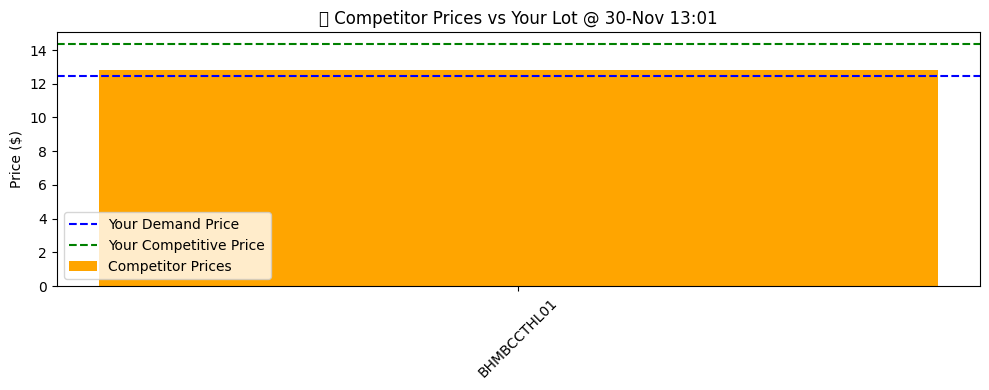

In [ ]:
import matplotlib.pyplot as plt

# Choose any timestamp and lot
chosen_time = model2_df['Timestamp'].iloc[1000]
chosen_lot = model2_df['ParkingLotID'].iloc[1000]

# Get details of the selected lot
lot_row = model2_df[
    (model2_df['ParkingLotID'] == chosen_lot) &
    (model2_df['Timestamp'] == chosen_time)
].iloc[0]

# Get all other lots at that time
competitors = model2_df[
    (model2_df['Timestamp'] == chosen_time) &
    (model2_df['ParkingLotID'] != chosen_lot)
].copy()

# Calculate distance from selected lot
competitors['Distance_km'] = competitors.apply(
    lambda row: haversine_distance(lot_row['Latitude'], lot_row['Longitude'], row['Latitude'], row['Longitude']),
    axis=1
)

# Filter nearby lots within 0.5 km
nearby = competitors[competitors['Distance_km'] <= 0.5]

# Plot
plt.figure(figsize=(10, 4))
plt.bar(nearby['ParkingLotID'], nearby['DemandPrice'], label='Competitor Prices', color='orange')
plt.axhline(y=lot_row['DemandPrice'], color='blue', linestyle='--', label='Your Demand Price')
plt.axhline(y=lot_row['CompetitivePrice'], color='green', linestyle='--', label='Your Competitive Price')

plt.title(f"🆚 Competitor Prices vs Your Lot @ {chosen_time.strftime('%d-%b %H:%M')}")
plt.ylabel("Price ($)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
